In [ ]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 1.4 MB/s 
     |████████████████████████████████| 468 kB 68.9 MB/s 
     |████████████████████████████████| 22.3 MB 1.1 MB/s 
     |████████████████████████████████| 981 kB 55.4 MB/s 
     |████████████████████████████████| 1.2 MB 19.8 MB/s 
     |████████████████████████████████| 2.8 MB 27.8 MB/s 
     |████████████████████████████████| 263 kB 72.4 MB/s 
     |████████████████████████████████| 596 kB 68.1 MB/s 
     |████████████████████████████████| 880 kB 64.6 MB/s 
     |████████████████████████████████| 3.3 MB 57.1 MB/s 
     |████████████████████████████████| 101 kB 9.9 MB/s 
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33517 sha256=c2c045c4f1ac7face06199312b62dd55aaec66a1c39924061770bb6f9aa31da0
  Stored in directory: /root/.cache/pip/wheels/a4/e8/45/842b3a39831261aef9154b907eacbc4ac99499a99ae829b06

In [ ]:

import ktrain
from ktrain import vision as vis
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import callbacks,optimizers


In [ ]:
train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale= 1./255)

In [ ]:
train_data = train.flow_from_directory('/content/drive/MyDrive/dataset/train',
                                          target_size=(200,200),
                                          batch_size=3,
                                          class_mode='categorical')

test_data = validation.flow_from_directory('/content/drive/MyDrive/dataset/test',
                                          target_size=(200,200),
                                          batch_size=3,
                                          class_mode='categorical')

Found 3164 images belonging to 11 classes.
Found 811 images belonging to 11 classes.


In [ ]:
train_data.class_indices

{'1': 0,
 '10': 1,
 '11': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}

In [ ]:
vis.print_image_regression_models()

pretrained_resnet50: 50-layer Residual Network (pretrained on ImageNet)
resnet50: 50-layer Resididual Network (randomly initialized) [https://arxiv.org/abs/1512.03385]
pretrained_mobilenet: MobileNet Neural Network (pretrained on ImageNet)
mobilenet: MobileNet Neural Network (randomly initialized) [https://arxiv.org/abs/1704.04861]
pretrained_mobilenetv3: MobileNetV3-Small Neural Network (pretrained on ImageNet)
mobilenetv3: MobileNetV3-Small Neural Network (randomly initialized) [https://arxiv.org/abs/1905.02244]
pretrained_inception: Inception Version 3  (pretrained on ImageNet)
inception: Inception Version 3 (randomly initialized) [http://arxiv.org/abs/1512.00567]
pretrained_efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet)
efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet) [https://arxiv.org/abs/1905.11946]
pretrained_efficientnetb7: EfficientNet-B7 Neural Network (pretrained on ImageNet)
efficientnetb7: EfficientNet-B7 Neural Network (pre

In [ ]:
model= vis.image_regression_model('pretrained_resnet50',
                                  train_data=train_data,
                                  val_data=test_data)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? False
94781440/94765736 [==============================] - 0s 0us/step
pretrained_resnet50 model created.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
import keras.backend as K

def f1_score(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss= 'categorical_crossentropy',
              optimizer = RMSprop(lr=0.001),
              metrics=['Precision','accuracy','Recall','AUC',f1_score])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict_generator(train_data )
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(train_data.classes, y_pred))
print('Classification Report')
target_names = ['0', '1','2','3','4','5','6','7','8','9','10']
print(classification_report(train_data.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
[[  2  46  22  86  13  97  16  38  11  17 204]
 [  8  53  26  88  16 106  17  41  33  18 262]
 [  3   8   4  16   1  24   4   4   3   1  46]
 [  2  12   5  19   5  44   5  13   5   5 102]
 [  2   8   6  10   2  26   1   9   2   2  38]
 [  1  11   3  18   1  26   6   8  12   2  49]
 [  0   5   2  10   0  16   2   3   2   1  28]
 [  5  49  15  81  15 102  15  37  23  15 249]
 [  1  13   2  17   0  23   2   2   4   2  51]
 [  6  31  12  52  13  91  10  16  14  13 182]
 [  2  16   6  14   1  25   4   5   5   4  56]]
Classification Report
              precision    recall  f1-score   support

           0       0.06      0.00      0.01       552
           1       0.21      0.08      0.12       668
           2       0.04      0.04      0.04       114
           3       0.05      0.09      0.06       217
           4       0.03      0.02      0.02       106
           5       0.04      0.19      0.07       137
           6       0.02      0.03      0.03        69
          

In [ ]:
learner = ktrain.get_learner(model=model,
                             train_data=train_data,
                             val_data=test_data,
                             batch_size=64)

In [ ]:
learner.fit_onecycle(1e-4,20)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ktrain/core.py:996: UserWarning: cyclical momentum has been disabled because optimizer is not "Adam-like" with beta_1 param
  "cyclical momentum has been disabled because "


50/50 [==============================] - 291s 6s/step - loss: 4.0893 - precision: 0.1809 - accuracy: 0.1707 - recall: 0.1248 - auc: 0.6090 - f1_score: 0.1473 - val_loss: 2.4882 - val_precision: 0.3067 - val_accuracy: 0.2639 - val_recall: 0.1517 - val_auc: 0.7374 - val_f1_score: 0.2021
Epoch 2/20
50/50 [==============================] - 12s 244ms/step - loss: 3.4067 - precision: 0.2624 - accuracy: 0.2396 - recall: 0.1893 - auc: 0.6836 - f1_score: 0.2182 - val_loss: 2.3968 - val_precision: 0.3265 - val_accuracy: 0.2935 - val_recall: 0.1973 - val_auc: 0.7662 - val_f1_score: 0.2471
Epoch 3/20
50/50 [==============================] - 12s 244ms/step - loss: 2.8602 - precision: 0.3403 - accuracy: 0.3059 - recall: 0.2481 - auc: 0.7480 - f1_score: 0.2879 - val_loss: 2.6345 - val_precision: 0.3137 - val_accuracy: 0.2824 - val_recall: 0.2096 - val_auc: 0.7476 - val_f1_score: 0.2491
Epoch 4/20
50/50 [==============================] - 12s 246ms/step - loss: 2.4162 - precision: 0.4124 - accuracy: 0.

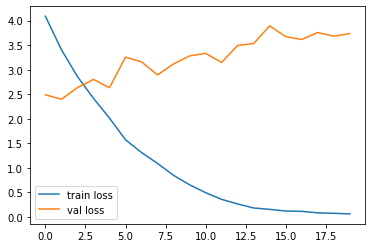

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(learner.history.history['loss'], label='train loss')
plt.plot(learner.history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')



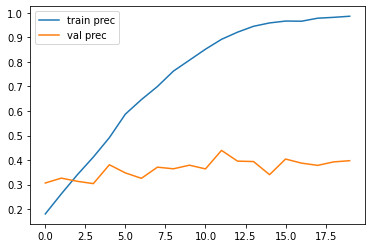

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot the precision
plt.plot(learner.history.history['precision'], label='train prec')
plt.plot(learner.history.history['val_precision'], label='val prec')
plt.legend()
plt.show()
plt.savefig('AccVal_prec')

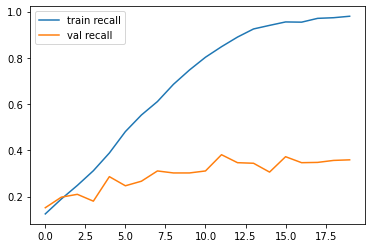

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot recall
plt.plot(learner.history.history['recall'], label='train recall')
plt.plot(learner.history.history['val_recall'], label='val recall')
plt.legend()
plt.show()
plt.savefig('AccVal_rec')

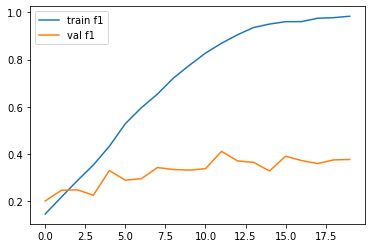

<Figure size 432x288 with 0 Axes>

In [ ]:

#plot f1_score
plt.plot(learner.history.history['f1_score'], label='train f1')
plt.plot(learner.history.history['val_f1_score'], label='val f1')
plt.legend()
plt.show()
plt.savefig('AccVal_f1')

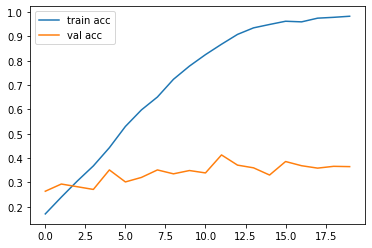

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the accuracy
plt.plot(learner.history.history['accuracy'], label='train acc')
plt.plot(learner.history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')






val [[1.1911554e-01 4.2547706e-01 1.0690116e-10 3.5874112e-04 1.9904559e-07
  2.3803757e-06 3.2107533e-07 4.3997562e-01 2.9413091e-08 1.5069388e-02
  6.7969569e-07]]
sadly disgusted 6


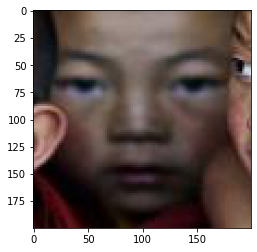

In [ ]:
img=image.load_img('/content/drive/MyDrive/dataset/test/11/test_025_aligned.jpg',target_size=(200,200))
plt.imshow(img)
X=image.img_to_array(img)
X=np.expand_dims(X,axis=0)
images=np.vstack([X])
val=model.predict(images)
print("val %s"%val)
rach=val.argmax()
if rach==0:
  print("happily surprised 1")
if rach==1:
  print("angrily disgusted 10")
if rach==2:
  print("disgustedly surprised 11")
if rach==3:
  print("happily disgusted 2")
if rach==10:
  print("sadly fearful 3")
if rach==5:
  print("sadly angry 4")
if rach==1:
  print("sadly surprised 5")
if rach==7:
  print("sadly disgusted 6")
if rach==8:
  print("fearfully angry 7")
if rach==9:
  print("fearfully surprised 8")
if rach==10:
  print("angrily surprised 9")

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
img=image.load_img('/content/photo.jpg',target_size=(200,200))
plt.imshow(img)
X=image.img_to_array(img)
X=np.expand_dims(X,axis=0)
images=np.vstack([X])
val=model.predict(images)
print("val %s"%val)
rach=val.argmax()
if rach==0:
  print("1")
if rach==1:
  print("10")
if rach==2:
  print("11")
if rach==3:
  print("2")
if rach==4:
  print("3")
if rach==5:
  print("4")
if rach==6:
  print("5")
if rach==7:
  print("6")
if rach==8:
  print("7")
if rach==9:
  print("8")
if rach==10:
  print("9")